In [1]:
!nvidia-smi
#!pip3 install transformers==4.10.2
#! pip3 install tabulate



Fri Nov 12 15:10:58 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 3090    Off  | 00000000:21:00.0 Off |                  N/A |
| 37%   42C    P3    68W / 350W |    102MiB / 24265MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 3090    Off  | 00000000:5B:00.0 Off |                  N/A |
| 30%   

In [2]:
import json
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
from pylab import rcParams
from tqdm.auto import tqdm

import pandas as pd
from pandas import json_normalize
import numpy as np
from tabulate import tabulate

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix

from transformers import AdamW, get_linear_schedule_with_warmup
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

import mlflow
import torchmetrics
import time
#from pytorch_lightning.metrics.functional import accuracy, f1, auroc

RANDOM_SEED = 42
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
pl.seed_everything(RANDOM_SEED)

Global seed set to 42


42

### Download and unzip dataset

In [3]:
def quick_look(data_raw):
    print("Number of rows in data =", data_raw.shape[0])
    print("Number of columns in data =", data_raw.shape[1])
    print("\n**Sample data:** \n")
    print(data_raw.head(300))
    
def count_each_label(df, path_to_save='figures/sinch/num_examples_per_label.png'):
    categories = list(df.columns.values[2:])
    sns.set(font_scale=2)
    plt.figure(figsize=(15, 8))
    label_columns = df.iloc[:, 2:]

    total_count = label_columns.where(label_columns > 0).sum().values
    for i in range(len(total_count)):
        print(categories[i], ': ', total_count[i], '\n')

    sns.barplot(total_count, categories)
    plt.title("Examples in each category", fontsize=24)
    plt.ylabel('Message type', fontsize=18)
    plt.xlabel('Number of messages', fontsize=18)

    plt.savefig(path_to_save)
    plt.show()

train_file_path = 'data/jigsaw-toxic-comment-classification-challenge/train.csv'
df = pd.read_csv(train_file_path)
LABEL_COLUMNS = df.columns.tolist()[2:]
print(df.head(5))

test_file_path = 'data/jigsaw-toxic-comment-classification-challenge/test.csv'
test_df = pd.read_csv(test_file_path)
#print(test_df.head())

test_labels_file_path = 'data/jigsaw-toxic-comment-classification-challenge/test_labels.csv'
test_labels_df = pd.read_csv(test_labels_file_path)

                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        0       0       0              0  
4             0        0       0       0              0  


### Preprocess the data

(14399, 8)
(137193, 8)
(4000, 8)
(500, 8)
(153164, 2)
toxic :  2106.0 

severe_toxic :  203.0 

obscene :  1165.0 

threat :  76.0 

insult :  1092.0 

identity_hate :  181.0 



/home/filmod/myenv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


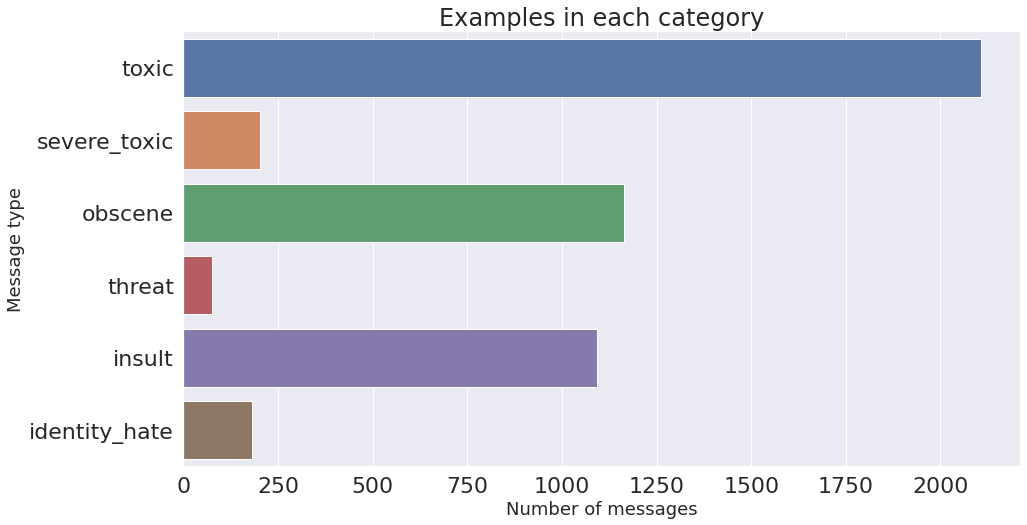

In [4]:
def get_datasets(non_labels=0.2):
    '''
        Preprocessing the data and returns train and validation datasets
    '''
        
     # Drop labels of training dataset according to the removal ratio
    num_labels_to_drop = int(non_labels * len(LABEL_COLUMNS))
    drop_col_idx = torch.randint(0, len(LABEL_COLUMNS), (df.shape[0], num_labels_to_drop))
    drop_row_idx = torch.arange(df.shape[0]).reshape(-1,1)
    drop_idx = torch.cat((drop_row_idx, drop_col_idx), 1).tolist()
    drop_idx = [list(map(int, item)) for item in drop_idx]
    #print(drop_idx[:10])
    
    for index in drop_idx:
        df.iat[index[0], index[1] + 2] = -1
        
    train_df, val_df = train_test_split(df, test_size=0.05)
    
    # To deal with imbalance in the dataset, a number of clean comments is removed
    train_toxic = train_df[train_df[LABEL_COLUMNS].sum(axis=1) >= 0]
    train_clean = train_df[train_df[LABEL_COLUMNS].sum(axis=1) < 0]
    
    print(train_toxic.shape)
    print(train_clean.shape)
    
    train_df = pd.concat([
        #train_toxic,
        #train_clean.sample(5_000)
        
        train_toxic.sample(2_500), # Just to test, change it later!
        train_clean.sample(1_500)
    ])
    
    val_df = val_df.sample(500) # Just to test, change it later!
    
    return train_df, val_df
    

train_df, val_df = get_datasets()
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)
del df

count_each_label(train_df)

### Tokenization

In [5]:
model_name = 'xlmr'

class MessageDataset(Dataset):
    
    def __init__(self, data:pd.DataFrame, tokenizer, max_token_len:int=128):
        self.tokenizer = tokenizer
        self.data = data
        self.max_token_len = max_token_len
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index:int):
        data_row = self.data.iloc[index]
        
        comment = data_row.comment_text
        labels = data_row[LABEL_COLUMNS]
        
        encoding = self.tokenizer.encode_plus(
            comment,
            add_special_tokens = True,
            max_length = self.max_token_len,
            return_token_type_ids=False,
            padding = "max_length",
            truncation = True,
            return_attention_mask = True,
            return_tensors = 'pt',
        )
        
        return dict(
            input_ids = encoding["input_ids"].flatten(),
            attention_mask=encoding["attention_mask"].flatten(),
            labels = torch.FloatTensor(labels)
        )
    
class MessageDataModule(pl.LightningDataModule):
    def __init__(self, train_df, val_df, tokenizer, batch_size=8, max_token_len=128):
        super().__init__()
        self.batch_size = batch_size
        self.train_df = train_df
        self.val_df = val_df
        #self.test_df = val_df # TODO: fix this in real project
        self.tokenizer = tokenizer
        self.max_token_len = max_token_len
        
    def setup(self, stage=None):
        self.train_dataset = MessageDataset(self.train_df, self.tokenizer, self.max_token_len)
        self.val_dataset = MessageDataset(self.val_df, self.tokenizer, self.max_token_len)
        #self.test_dataset = ToxicCommentsDataset(self.test_df, self.tokenizer, self.max_token_len)
    
    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=48)
    
    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=48)
    
    #def test_dataloader(self):
        #return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=48)
        
        
class MessageTagger(pl.LightningModule):
    def __init__(self, n_classes:int, n_training_steps=None, n_warmup_steps=None):
        super().__init__()
        if model_name == 'xlmr-base':
            from transformers import XLMRobertaModel
            self.model = XLMRobertaModel.from_pretrained('xlm-roberta-base', return_dict=True)
        elif model_name == 'xlmr-large':
            from transformers import XLMRobertaModel
            self.model = XLMRobertaModel.from_pretrained('xlm-roberta-large', return_dict=True)
        elif model_name == 'labse':
            from transformers import BertModel
            self.model = BertModel.from_pretrained('sentence-transformers/LaBSE', return_dict=True)
        else:
            raise NameError('Invalid model name')
            
        self.classifier = nn.Linear(self.model.config.hidden_size, n_classes) # Define the classifier
        self.n_training_steps = n_training_steps
        self.n_warmup_steps = n_warmup_steps
        self.criterion = nn.BCELoss(reduction='sum') # Define the loss function
        
        
    def forward(self, input_ids, attention_mask, labels=None):
        output = self.model(input_ids, attention_mask=attention_mask)
        output = self.classifier(output.pooler_output) 
        output = torch.sigmoid(output)
        loss = 0
        if labels is not None:        
            mask = ~labels.eq(-1)
            loss = self.criterion(output*mask, labels*mask)
            
            #loss = self.criterion(output, labels)
        return loss, output
    
    def training_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        loss, outputs = self(input_ids, attention_mask, labels)
        self.log("train_loss", loss, prog_bar=True, logger=True)
        return {"loss": loss, "predictions": outputs, "labels": labels}
    
    def validation_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        loss, _ = self(input_ids, attention_mask, labels)
        self.log("val_loss", loss, prog_bar=True, logger=True)
        return loss
        
    #def test_step(self, batch, batch_idx):
        #input_ids = batch["input_ids"]
        #attention_mask = batch["attention_mask"]
        #labels = batch["labels"]
        #loss, _ = self(input_ids, attention_mask, labels)
        #self.log("test_loss", loss, prog_bar=True, logger=True)
        #return loss
            
    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), lr=2e-5)
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps = self.n_warmup_steps,
            num_training_steps = self.n_training_steps
        )
        
        return dict(optimizer = optimizer, lr_scheduler = dict(scheduler = scheduler, interval = 'step'))
    
  

In [6]:
def multilabel_confusion_matrix(y_true, y_pred):
    np.testing.assert_array_equal(y_true.shape, y_pred.shape)
    n_examples = y_true.shape[0]
    
    tp = n_examples - np.count_nonzero(y_true + y_pred - 2, axis=0)
    fp = n_examples - np.count_nonzero(y_true - y_pred + 1, axis=0)
    fn = n_examples - np.count_nonzero(y_true - y_pred - 1, axis=0)
    tn = n_examples - np.count_nonzero(y_true + y_pred, axis=0)
    
    return tp, fp, fn, tn

def global_accuracy(tp, fp, fn, tn):
    return np.sum([tp, tn]) / np.sum([tp, fp, fn, tn])

def global_precision(tp, fp, fn, tn):
    with np.errstate(divide='ignore', invalid='ignore'):
        return np.nan_to_num(np.sum(tp) / np.sum([tp, fp]))

def global_recall(tp, fp, fn, tn):
    return np.sum(tp) / np.sum([tp, fn])

def micro_f1_score(tp, fp, fn, tn):
    precision = global_precision(tp, fp, fn, tn)
    recall = global_recall(tp, fp, fn, tn)
    with np.errstate(divide='ignore', invalid='ignore'):
        return np.nan_to_num(2 * (precision * recall) / (precision + recall))
    
def multilabel_accuracy(tp, fp, fn, tn):
    #print(np.sum([tp, fp, fn, tn], axis=0))
    with np.errstate(divide='ignore', invalid='ignore'):
        return np.nan_to_num((tp + tn) / np.sum([tp, fp, fn, tn], axis=0))

def multilabel_precision(tp, fp, fn, tn):
    #print(np.sum([fp, tp], axis=0))
    with np.errstate(divide='ignore', invalid='ignore'):
        return np.nan_to_num(tp / np.sum([fp, tp], axis=0))

def multilabel_recall(tp, fp, fn, tn):
    #print(np.sum([fn, tp], axis=0))
    with np.errstate(divide='ignore', invalid='ignore'):
        return np.nan_to_num(tp / np.sum([fn, tp], axis=0))

def multilabel_f1_score(tp, fp, fn, tn):
    #print(np.sum([fn, tp], axis=0))
    precision = multilabel_precision(tp, fp, fn, tn)
    recall = multilabel_recall(tp, fp, fn, tn)
    with np.errstate(divide='ignore', invalid='ignore'):
        return np.nan_to_num(2 * (precision * recall) / (precision + recall))

def print_classification_report(y_true, y_pred, classes):
    tp, fp, fn, tn = multilabel_confusion_matrix(y_true, y_pred)
    accuracy = multilabel_accuracy(tp, fp, fn, tn).round(decimals=3)
    precision = multilabel_precision(tp, fp, fn, tn).round(decimals=3)
    recall = multilabel_recall(tp, fp, fn, tn).round(decimals=3)
    f1_score = multilabel_f1_score(tp, fp, fn, tn).round(decimals=3)
    content1 = np.stack((classes, accuracy, precision, recall, f1_score)).T
    #print(content1)
    
    micro_accuracy = global_accuracy(tp, fp, fn, tn).round(decimals=3)
    micro_precision = global_precision(tp, fp, fn, tn).round(decimals=3)
    micro_recall = global_recall(tp, fp, fn, tn).round(decimals=3)
    m_f1_score = micro_f1_score(tp, fp, fn, tn).round(decimals=3)
    macro_accuracy = np.mean(multilabel_accuracy(tp, fp, fn, tn)).round(decimals=3)
    macro_precision = np.mean(multilabel_precision(tp, fp, fn, tn)).round(decimals=3)
    macro_recall = np.mean(multilabel_recall(tp, fp, fn, tn)).round(decimals=3)
    macro_f1_score = np.mean(multilabel_f1_score(tp, fp, fn, tn)).round(decimals=3)
    content2 = [['micro avg', micro_accuracy, micro_precision, micro_recall, m_f1_score], 
               ['macro avg', macro_accuracy, macro_precision, macro_recall, macro_f1_score]]
    mlflow.log_metric('accuracy', macro_accuracy)
    mlflow.log_metric('precision', macro_precision)
    mlflow.log_metric('recall', macro_recall)
    mlflow.log_metric('f1-score', macro_f1_score)
    
    empty_row = [['', '', '', '', '']]
    
    content = np.concatenate((content1, empty_row, content2))

    headers = ['accuracy', 'precision', 'recall', 'f1_score']
    print(tabulate(content, headers=headers, floatfmt=".3f"))
    

In [7]:
def test_model(trainer, tokenizer, test_df, test_labels_df, MAX_TOKEN_COUNT):
    THRESHOLD = 0.5
    
    print('path:', trainer.checkpoint_callback.best_model_path)
    mlflow.log_param('best_model_path', trainer.checkpoint_callback.best_model_path)
    
    test_df = test_labels_df.join(test_df['comment_text'])
    test_df.drop(test_df[test_df.toxic == -1].index,inplace=True)
    
    start = time.time()
    trained_model = MessageTagger.load_from_checkpoint(
        trainer.checkpoint_callback.best_model_path,
        #'/home/filmod/master-thesis/checkpoints/sinch/best-checkpoint.ckpt',
        n_classes = len(LABEL_COLUMNS)
    )
    print(f"************ Total loading time: {time.time() - start}")

    trained_model.eval()
    trained_model.freeze()
    
    # Test one example
    test_sample = test_df.sample(1)
    print(test_sample)
    
    start = time.time()
    encoding = tokenizer.encode_plus(
      str(test_sample.comment_text),
      add_special_tokens=True,
      max_length=MAX_TOKEN_COUNT,
      return_token_type_ids=False,
      padding="max_length",
      return_attention_mask=True,
      return_tensors='pt',
    )
    _, test_prediction = trained_model(encoding["input_ids"], encoding["attention_mask"])
    print(f"************ Total inference time: {time.time() - start}")
    test_prediction = test_prediction.flatten().numpy()
    for label, prediction in zip(LABEL_COLUMNS, test_prediction):
      print(f"{label}: {prediction}")
    
    # Calculate the metrics
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    trained_model = trained_model.to(device)

    print(test_df.shape)
    # count_each_label(test_df)

    test_dataset = MessageDataset(
      test_df.sample(500),
      #test_df,
      tokenizer,
      max_token_len=MAX_TOKEN_COUNT
    )
    
    predictions = []
    labels = []

    for item in tqdm(test_dataset):
        _, prediction = trained_model(
            item["input_ids"].unsqueeze(dim=0).to(device),
            item["attention_mask"].unsqueeze(dim=0).to(device)
          )
        predictions.append(prediction.flatten())
        labels.append(item["labels"].int())

    predictions = (torch.stack(predictions)>THRESHOLD).float().detach().cpu().numpy()
    labels = torch.stack(labels).detach().cpu().numpy()
    
    print_classification_report(labels, predictions, LABEL_COLUMNS)
    

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/filmod/myenv/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:147: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=True)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointi

Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: 0it [00:00, ?it/s]

/home/filmod/myenv/lib/python3.8/site-packages/pytorch_lightning/loops/optimization/closure.py:35: LightningDeprecationWarning: One of the returned values {'labels', 'predictions'} has a `grad_fn`. We will detach it automatically but this behaviour will change in v1.6. Please detach it manually: `return {'loss': ..., 'something': something.detach()}`
  rank_zero_deprecation(


Validating: 0it [00:00, ?it/s]

Epoch 0, global step 499: val_loss reached 4.62628 (best 4.62628), saving model to "/home/filmod/master-thesis/checkpoints/sinch/best-checkpoint-v6.ckpt" as top 1


************ Total training time: 53.8060200214386
path: /home/filmod/master-thesis/checkpoints/sinch/best-checkpoint-v6.ckpt


Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


************ Total loading time: 3.3968734741210938
                      id  toxic  severe_toxic  obscene  threat  insult  \
122056  cbd83ffa0927bc8d      1             0        0       0       0   

        identity_hate                                       comment_text  
122056              0  " \n\n == Alleged Original Research == \n\n I ...  
************ Total inference time: 0.13383984565734863
toxic: 0.12200227379798889
severe_toxic: 0.014188550412654877
obscene: 0.03339451923966408
threat: 0.026404114440083504
insult: 0.044076476246118546
identity_hate: 0.027269134297966957
(63978, 8)


  0%|          | 0/500 [00:00<?, ?it/s]

               accuracy    precision    recall    f1_score
-------------  ----------  -----------  --------  ----------
toxic          0.816       0.343        0.959     0.505
severe_toxic   0.99        0.0          0.0       0.0
obscene        0.934       0.5          0.939     0.653
threat         0.996       0.0          0.0       0.0
insult         0.926       0.417        0.926     0.575
identity_hate  0.986       0.0          0.0       0.0

micro avg      0.941       0.398        0.837     0.539
macro avg      0.941       0.21         0.471     0.289


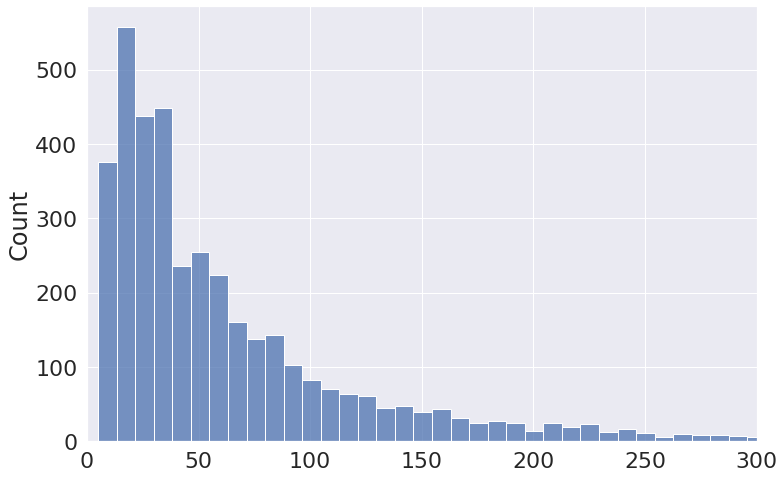

In [8]:
def main(model_name, max_epoch):
    MAX_TOKEN_COUNT = 200
    
    if model_name == 'xlmr-base':
        from transformers import XLMRobertaTokenizer
        MODEL_NAME = 'xlm-roberta-base'
        tokenizer = XLMRobertaTokenizer.from_pretrained(MODEL_NAME)
        MAX_TOKEN_COUNT = 200
    elif model_name == 'xlmr-large':
        from transformers import XLMRobertaTokenizer
        MODEL_NAME = 'xlm-roberta-large'
        tokenizer = XLMRobertaTokenizer.from_pretrained(MODEL_NAME)
        MAX_TOKEN_COUNT = 100
    elif model_name == 'labse':
        from transformers import BertTokenizer
        MODEL_NAME = 'sentence-transformers/LaBSE'
        tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
        MAX_TOKEN_COUNT = 100
    else:
        raise NameError('Invalid model name')
    
    token_counts = []

    for _,row in train_df.iterrows():
        token_count = len (tokenizer.encode(
                row["comment_text"],
                max_length=512,
                truncation=True
            )
        )
        token_counts.append(token_count)

    sns.histplot(token_counts)
    plt.xlim([0, 300])
    
    N_EPOCHS = max_epoch
    BATCH_SIZE = 8
    data_module = MessageDataModule(train_df, val_df, tokenizer, batch_size=BATCH_SIZE, max_token_len=MAX_TOKEN_COUNT)

    steps_per_epoch = len(train_df) // BATCH_SIZE
    total_training_steps = steps_per_epoch * N_EPOCHS
    warmup_steps = total_training_steps // 5
    # warmup_steps, total_training_steps

    model = MessageTagger(
        n_classes=len(LABEL_COLUMNS),
        n_warmup_steps=warmup_steps,
        n_training_steps=total_training_steps
    )
    
    checkpoint_callback = ModelCheckpoint(
        dirpath="checkpoints/sinch",
        filename="best-checkpoint",
        save_top_k=1,
        verbose=True,
        monitor="val_loss",
        mode="min"
    )

    logger = TensorBoardLogger("lightning_logs", name = "sinch_setup1")
    early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 2)

    trainer = pl.Trainer(
        logger = logger,
        checkpoint_callback = True,
        callbacks = [checkpoint_callback, early_stopping_callback],
        max_epochs = N_EPOCHS,
        gpus=1,
        progress_bar_refresh_rate=30
    )
    
    EXPERIMENT_NAME = 'Multi-label classification - Sinch data'
    experiment_id = mlflow.set_experiment(EXPERIMENT_NAME)
    #mlflow.pytorch.autolog()

    with mlflow.start_run(experiment_id=experiment_id, run_name=model_name) as run:
        mlflow.log_param('model', MODEL_NAME)
        mlflow.log_param('classifier', 'Linear')
        mlflow.log_param('criterion', 'BCELoss')
        mlflow.log_param('max_epoch', N_EPOCHS)
        mlflow.log_param('batch_size', BATCH_SIZE)
        
        start = time.time()
        trainer.fit(model, data_module)
        end = time.time()
        print(f"************ Total training time: {end - start}")
        
        test_model(trainer, tokenizer, test_df, test_labels_df, MAX_TOKEN_COUNT)
        
model_name = 'xlmr-base'
main(model_name, 1)   